dane pobrane z kaggle  https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?select=creditcard.csv

In [1]:
import pandas as pd
import numpy as np

dataset = pd.read_csv("creditcard.csv")

In [ ]:
# przyglądnę się danym i ewentualnie zredukuję listę zmiennych
from dataprep.eda import create_report

report = create_report(dataset, title='EDA dla zbioru fraudów kart kredytowych')
# przenoszę do przeglądarki
report.save( "EDA_dla_KK.html")
report.show_browser()
report.show()

In [3]:
#I jeszcze kilka najważniejszych informacji poza raportem, żeby nie wchodzić do niego za każdym razem
#check for any  nullvalues 
print("Czy są jakiekolwiek nulle w zbiorze danych ",dataset.isnull().values.any() )
print('-------')
print("Liczba unikatowych kategorii celu ", len(dataset['Class'].unique()))
print("Wartości zmiennej celu ",dataset.Class.unique())
#0 prawidłowa transakcja KK
#1 transakcja fraudowa
print('-------')
print("Rozkład transkacji")
print(pd.value_counts(dataset['Class'], sort = True) )


Czy są jakiekolwiek nulle w zbiorze danych  False
-------
Liczba unikatowych kategorii celu  2
Wartości zmiennej celu  [0 1]
-------
Rozkład transkacji
0    284315
1       492
Name: Class, dtype: int64


W pierszej kolejności analiza nadzorowana. W tym celu wykorzystam metodę ADASYN oversamplingu, która skupia się na powielaniu elementów właśnie odstających co spowoduje wyeksponowanie właśnie nietypowych transakcji

In [4]:
# 1. Rozdzoelam zbiór na charakrerystyki roaz zmienną celu 


y = pd.Series(dataset['Class'])
X = dataset.drop('Class', axis=1)
#X.drop('ID', axis=1, inplace=True)


In [7]:
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=128262)

osa = ADASYN(random_state=128262)
kolumny = X_train.columns


osa_data_X, osa_data_y=osa.fit_resample(X_train, y_train)
osa_data_X = pd.DataFrame(data=osa_data_X, columns=kolumny)
osa_data_y= pd.DataFrame(data=osa_data_y, columns=['Class'])


In [8]:
# sprawdzenie czy dane zostały zbalansowane
print("Długość zbioru nadpróbkowego:",len(osa_data_X))
print("Liczba pozytywnych targetów:",len(osa_data_y[osa_data_y['Class']==1]))
print("Liczba negatywnych targetów:",len(osa_data_y[osa_data_y['Class']==0]))
print("Proporcja pozytywnych targetów:",len(osa_data_y[osa_data_y['Class']==1])/len(osa_data_X))
print("Proporcja negatywnych targetów:",len(osa_data_y[osa_data_y['Class']==0])/len(osa_data_X))

Długość zbioru nadpróbkowego: 455048
Liczba pozytywnych targetów: 227600
Liczba negatywnych targetów: 227448
Proporcja pozytywnych targetów: 0.5001670153478315
Proporcja negatywnych targetów: 0.4998329846521686


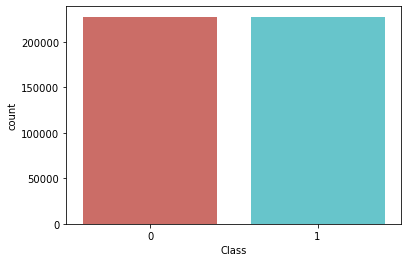

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x= 'Class', data=osa_data_y,  palette='hls')
plt.show()

####Bubujemy model z losowo dobranymi hiperparametramiimport xgboost as xgb

Dokładność dla zbioru walidacyjnego: 0.9975
Dokładność dla zbioru traningowego oryginalnego: 0.9982
Dokładność dla zbioru traningowego zbalansowanego: 0.9989
Precision dla zbioru walidacyjnego: 0.3905
Precision dla zbioru traningowego oryginalnego: 0.4943
Precision dla zbioru traningowego zbalansowanego: 0.9982
Recall dla zbioru walidacyjnego: 0.8632
Recall dla zbioru traningowego oryginalnego: 0.9824
Recall dla zbioru traningowego zbalansowanego: 0.9995
Wartość parametru Gini na zbiorze walidacyjnym to: 0.9765
Wartość parametru Gini na zbiorze treningowym to: 0.9998
Wartość parametru Gini na zbiorze zbalansowanym to: 0.9999

ROC Curve

Confusion Matrix


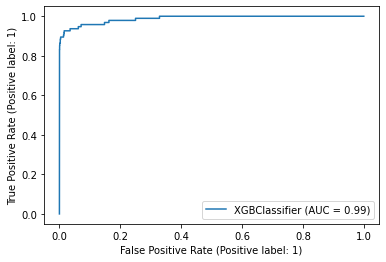

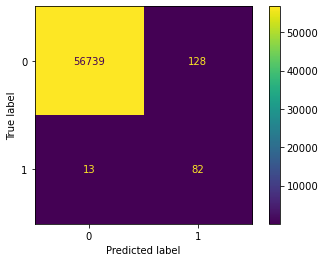

In [16]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score

xgb_clf = xgb.XGBClassifier(max_depth=3,
                            n_estimators=100,
                            objective='binary:logistic',
                            booster='gbtree',
                            n_jobs=-1,
                            random_state=1)

# uczymy model, korzystamy z API sklearn
xgb_clf.fit(osa_data_X, osa_data_y)

# przeliczamy skoringi na zbiorze testowym aby sprawdzić jakość modelu w rozumieniu interesujących mnie miar
y_hat = xgb_clf.predict(X_test)

auc_val = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
auc_train = roc_auc_score(y_train, xgb_clf.predict_proba(X_train)[:, 1])
auc_train_osa = roc_auc_score(osa_data_y, xgb_clf.predict_proba(osa_data_X)[:, 1])


print("Dokładność dla zbioru walidacyjnego: {0:.4f}".format(accuracy_score(y_test, y_hat)))
print("Dokładność dla zbioru traningowego oryginalnego: {0:.4f}".format(accuracy_score(y_train, xgb_clf.predict(X_train))))
print("Dokładność dla zbioru traningowego zbalansowanego: {0:.4f}".format(accuracy_score(osa_data_y, xgb_clf.predict(osa_data_X))))

# w tym wypadku nas najbardziej interesować będzie recall czyli ile nam udało się namierzyć fraudów, precyzja i accuracy już trochę mniej

print("Precision dla zbioru walidacyjnego: {0:.4f}".format(precision_score(y_test, y_hat)))
print("Precision dla zbioru traningowego oryginalnego: {0:.4f}".format(precision_score(y_train, xgb_clf.predict(X_train))))
print("Precision dla zbioru traningowego zbalansowanego: {0:.4f}".format(precision_score(osa_data_y, xgb_clf.predict(osa_data_X))))

print("Recall dla zbioru walidacyjnego: {0:.4f}".format(recall_score(y_test, y_hat)))
print("Recall dla zbioru traningowego oryginalnego: {0:.4f}".format(recall_score(y_train, xgb_clf.predict(X_train))))
print("Recall dla zbioru traningowego zbalansowanego: {0:.4f}".format(recall_score(osa_data_y, xgb_clf.predict(osa_data_X))))



print("Wartość parametru Gini na zbiorze walidacyjnym to: {0:.4f}".format(2*auc_val-1)) # Gini = 2*AUC-1
print("Wartość parametru Gini na zbiorze treningowym to: {0:.4f}".format(2*auc_train-1)) # Gini = 2*AUC-1
print("Wartość parametru Gini na zbiorze zbalansowanym to: {0:.4f}".format(2*auc_train_osa-1)) # Gini = 2*AUC-1


print("\nROC Curve")
print(RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test))
#RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test)
#plt.savefig(r"E:\page_ds\XGBoost_step_by_step\foto\2_ROC_cur_clf.png", format="png" , dpi=300, facecolor="White")

print("\nConfusion Matrix")
cm = confusion_matrix(y_test, y_hat, labels=xgb_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgb_clf.classes_)
print(disp.plot())
#wyk = disp.plot()
#plt.savefig(r"E:\page_ds\XGBoost_step_by_step\foto\1_conf_matrix_clf.png", format="png" , dpi=300, facecolor="White")
#lt.show()

Komentarze: 
    Precision dla zbioru walidacyjnego: 0.3905 czyli 60% ze wzkazanych transakcji będzie niezadowolona ze względu na np. zablokowanie tej transakcji, ale mimo wszystko wydaje się to mała skala (prawie 57k transakcji)
    Recall dla zbioru walidacyjnego: 0.8632  - jak dla mnie świetnie, wychwyciliśmy ponad 86% fraudów 
    

### Powtarzam ćwiczenie ale wykorzystam teraz metodę SMOTE: 

In [17]:
from imblearn.over_sampling import SMOTE

oss = SMOTE(random_state=128262)

oss_data_X, oss_data_y=oss.fit_resample(X_train, y_train)
oss_data_X = pd.DataFrame(data=oss_data_X, columns=kolumny)
oss_data_y= pd.DataFrame(data=oss_data_y, columns=['Class'])

Dokładność dla zbioru walidacyjnego: 0.9979
Dokładność dla zbioru traningowego oryginalnego: 0.9985
Dokładność dla zbioru traningowego zbalansowanego: 0.9989
Precision dla zbioru walidacyjnego: 0.4323
Precision dla zbioru traningowego oryginalnego: 0.5385
Precision dla zbioru traningowego zbalansowanego: 0.9985
Recall dla zbioru walidacyjnego: 0.8737
Recall dla zbioru traningowego oryginalnego: 0.9874
Recall dla zbioru traningowego zbalansowanego: 0.9993
Wartość parametru Gini na zbiorze walidacyjnym to: 0.9754
Wartość parametru Gini na zbiorze treningowym to: 0.9999
Wartość parametru Gini na zbiorze zbalansowanym to: 0.9999

ROC Curve

Confusion Matrix


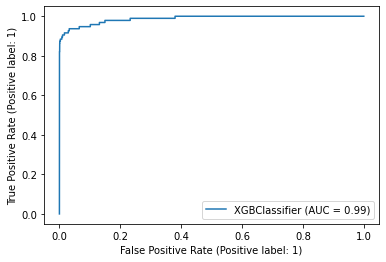

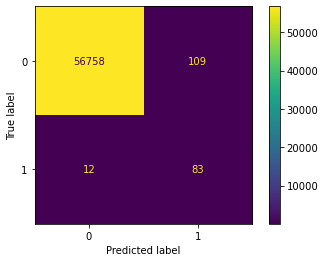

In [18]:
xgb_clf_oss = xgb.XGBClassifier(max_depth=3,
                            n_estimators=100,
                            objective='binary:logistic',
                            booster='gbtree',
                            n_jobs=-1,
                            random_state=1)

# uczymy model, korzystamy z API sklearn
xgb_clf_oss.fit(oss_data_X, oss_data_y)

# przeliczamy skoringi na zbiorze testowym aby sprawdzić jakość modelu w rozumieniu interesujących mnie miar
y_hat_s = xgb_clf_oss.predict(X_test)

auc_val_oss = roc_auc_score(y_test, xgb_clf_oss.predict_proba(X_test)[:, 1])
auc_train_oss = roc_auc_score(y_train, xgb_clf_oss.predict_proba(X_train)[:, 1])
auc_train_oss = roc_auc_score(oss_data_y, xgb_clf_oss.predict_proba(oss_data_X)[:, 1])


print("Dokładność dla zbioru walidacyjnego: {0:.4f}".format(accuracy_score(y_test, y_hat_s)))
print("Dokładność dla zbioru traningowego oryginalnego: {0:.4f}".format(accuracy_score(y_train, xgb_clf_oss.predict(X_train))))
print("Dokładność dla zbioru traningowego zbalansowanego: {0:.4f}".format(accuracy_score(osa_data_y, xgb_clf_oss.predict(osa_data_X))))

# w tym wypadku nas najbardziej interesować będzie recall czyli ile nam udało się namierzyć fraudów, precyzja i accuracy już trochę mniej

print("Precision dla zbioru walidacyjnego: {0:.4f}".format(precision_score(y_test, y_hat_s)))
print("Precision dla zbioru traningowego oryginalnego: {0:.4f}".format(precision_score(y_train, xgb_clf_oss.predict(X_train))))
print("Precision dla zbioru traningowego zbalansowanego: {0:.4f}".format(precision_score(osa_data_y, xgb_clf_oss.predict(osa_data_X))))

print("Recall dla zbioru walidacyjnego: {0:.4f}".format(recall_score(y_test, y_hat_s)))
print("Recall dla zbioru traningowego oryginalnego: {0:.4f}".format(recall_score(y_train, xgb_clf_oss.predict(X_train))))
print("Recall dla zbioru traningowego zbalansowanego: {0:.4f}".format(recall_score(osa_data_y, xgb_clf_oss.predict(osa_data_X))))



print("Wartość parametru Gini na zbiorze walidacyjnym to: {0:.4f}".format(2*auc_val_oss-1)) # Gini = 2*AUC-1
print("Wartość parametru Gini na zbiorze treningowym to: {0:.4f}".format(2*auc_train_oss-1)) # Gini = 2*AUC-1
print("Wartość parametru Gini na zbiorze zbalansowanym to: {0:.4f}".format(2*auc_train_oss-1)) # Gini = 2*AUC-1


print("\nROC Curve")
print(RocCurveDisplay.from_estimator(xgb_clf_oss, X_test, y_test))
#RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test)
#plt.savefig(r"E:\page_ds\XGBoost_step_by_step\foto\2_ROC_cur_clf.png", format="png" , dpi=300, facecolor="White")

print("\nConfusion Matrix")
cm = confusion_matrix(y_test, y_hat_s, labels=xgb_clf_oss.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgb_clf_oss.classes_)
print(disp.plot())
#wyk = disp.plot()
#plt.savefig(r"E:\page_ds\XGBoost_step_by_step\foto\1_conf_matrix_clf.png", format="png" , dpi=300, facecolor="White")
#lt.show()

Co ciekawe, poprawił się recall! i nieco precyzja!

### Teraz analiza za pomocą autoencodera